# Implementing Machine Learning Model to Predict and Select Loan
## *Case Example: LendingClub Loan Data*

#### Contents

**[1. Introduction](#1_introduction)**

**[2. Dataset Preparation](#2-dataset-preparation)**

**[3. Features Preparation](#3-features-preparation)**

**[4. Model Selection](#4-model-selection)**

**[5. Feature Engineering](#5-fature-engineering)**

**[6. Hyperparameter Optimization](#6-hyperparameter)**

**[7. Model Implementation: Selecting Profitable Loan](#7-model-implementation)**

**[7.1. Preparation](#7.1-preparation)**

**[7.2. Knapsack Problem and Solving using *Pyomo*](#7.2-develop-selectors)**

**[7.3. Comparation of each Selector Performance](#7.3-comparations)**

**[8. Final Words](#8-final-words)**

<a id="1_introduction"> </a>
## 1. Introduction

In a particular day, a coworker introduced you to a website, called *LendingClub Loan*, a loan marketplace which allow you to purchase loans individually in a hope to yield a profit from its interest. Having spare money, you decided to take a look at what it provides. You overwhelmed with the list of loans to choose, alongside with loan profile as well as borrowers' financial profile and history. Maybe you can look at the loan rating but is it enough to decide whether the loan will yield profit or maybe defaulted?

Executing an informed-decision by gathering and evaluation some of relevant information must help us to reduce the risk of regret, but sometimes is highly time-consuming. In this occasion, I will demonstrate an acitivity to develop a machine learning model for solving classification problem, that may serves as *decision support system*. I will utilize LendingClub Loan data as an example in this analysis.


*P.S. Individual Loan is currently not available at LendingClub Loan. Above narration is provided just to describe the situation that related to the dataset.*

#### **What to Do?**


To help deciding whether particular loans will yield profit or has a chance of default, we will develop a classification model that train from the data of LendingClub Loan from the past. The model shall be able to predict the quality of the loan. Later, we will implement the model to build a simple algorithm that decide which loan should we invested on, this is to demonstrate utilizing the model as some sort of informed-decision.

We will perform some activity that commonly involved in model development, from preparation of training instances, selecting possible model that potential, tweaking our data, until optimizing the model's parameters. Later, we will explore some ways to utilize information that can be retrieved from the model and finalize the method of loan selection.

Note that this analysis is for demonstration purposes only and doesn't encourage anyone to implement this kind of analysis outside of this coverage. Investment should involve expert in their area.

#### **Performance Evaluation of Model**

In general, the model should be able to predict if the loan is *Good Loan* or *Bad Loan*. Let's see below confusion matrix of our prediction:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: left;">
      <th>Actual/Prediction</th>
      <th>Good Loan [0]</th>
      <th>Bad Loan [1]</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Good loan [0]</th>
      <td>TN</td>
      <td>FP</td>
    </tr>
    <tr>
      <th>Bad Loan [1]</th>
      <td>FN</td>
      <td>TP</td>
    </tr>
  </tbody>
</table>

So, what metric shall we use for our model? Consider this:

- We want model to be able to detect most of (if not all) possibly defaulted loan as much. For example, if there would be 10 loan to be defaulted, our model would be reliable  if most of those loan is tagged as `Bad Loan`. The metric is **sensitivity** (or *True Positive Rate*): the ratio of positive instances that are correctly detected by the model,

$$sensitivity/TPR=\frac{TP}{FN + TP}$$
         
- In an extreme case, **TPR** can be inflated by a model that tag all of the loan as `Bad Loan`, resulting in a huge number of *False Positive* prediction: most of the `Good Loan` tagged as `Bad Loan`. Therefore, another metric to watch is **FPR** (or *False Positive Rate*): the ratio of negative instance that are incorrectly tagged as positive instance,

$$FPR=\frac{FP}{TN + FP}$$

- TPR is the ability of the model to detect potential loss, which should be avoided. On the other side, FPR is the consequence of its high sensitivity to positive instance, in our cases, we would miss potential profit. We want to optimize trade-off between both metrics. They are commonly considered in **Receiver Operating Characteristic** (ROC): Comparation of *TPR* and *FPR*.

<a id="2-dataset-preparation"> </a>
## 2. Dataset Preparation

#### **The Dataset**

We already prepared the exclusively for training and testing:

- Dataset for training: Loan Dataset of 2010 - 2015
- Dataset for testing: Loan Dataset of 2016 - 2017

In [1]:
import pandas as pd
import numpy as np
# plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
# iteration checking

# base setting
pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 75)
pd.set_option('display.max_rows', 75)
matplotlib.verbose = 'ERROR'
# import data
train_set = pd.read_csv('dataset\lc_2010-2015.csv', dtype={'desc': 'str', 'verification_status_joint': 'str'})
test_set = pd.read_csv('dataset\lc_2016-2017.csv', dtype={'desc': 'str', 'verification_status_joint': 'str'})

#### **Preparing the Dataset**

In this first part of dataset preparation, we will create a pipeline to transform the dataset which consists of:

- Filtering the dataset: 1) To consider only `INDIVIDUAL` loan; 2) To exclude the on-going loan
- Replacing missing values, as explained in previous section.

I already developed classes for each of the activity: 1) `LoanDataLabelPredictor` for filtering; 2) `LoanDataMissingHandler` to handle missing data, according to explanation in previous chapter. The output of the pipeline is splitted predictor-label set.

In [2]:
from sklearn.pipeline import Pipeline
from modules.data_preprocess import LoanDataPreprocess, LoanDataMissingHandler, LoanDataLabelPredictor 
from sklearn import set_config

dataset_preprocess = Pipeline([
    ('preprocess', LoanDataPreprocess()),
    ('extract_label_predictor', LoanDataLabelPredictor(exclude=['loan_amnt', 'term', 'earliest_cr_line'])),
    ('missing_handler', LoanDataMissingHandler())
    ])

set_config(display='diagram')
dataset_preprocess

Pipeline(steps=[('preprocess', LoanDataPreprocess()),
                ('extract_label_predictor',
                 LoanDataLabelPredictor(exclude=['loan_amnt', 'term',
                                                 'earliest_cr_line'])),
                ('missing_handler', LoanDataMissingHandler())])

Checking the missing data:

In [3]:
from modules.data_exploration import DataExploration

X_train, y_train = dataset_preprocess.fit_transform(train_set)
DataExploration(X_train).show_nans_or_zeroes('nans')

,Nans Count,Nans Percentage (%),Data Types
emp_length,9132,4.34,category
home_ownership,0,0.00,category
annual_inc,0,0.00,float64
verification_status,0,0.00,category
dti,0,0.00,float64
delinq_2yrs,0,0.00,float64
inq_last_6mths,0,0.00,float64
mths_since_last_delinq,0,0.00,float64
mths_since_last_record,0,0.00,float64
open_acc,0,0.00,float64


Using above pipeline, we can transform the test set using clear and easier code.

In [4]:
X_test, y_test = dataset_preprocess.transform(test_set)

Based on previous confusion matrix, we will map the label as follows:

In [5]:
def map_array(x):
    if x == 'Good Loan':
        return 0
    return 1

y_train = np.vectorize(map_array)(y_train)
y_test = np.vectorize(map_array)(y_test)

<a id="3-features-preparation"> </a>
## 3. Features Preparation

#### **Categorical Features**

For categorical features, we will use *one-hot encoding* as below:

In [6]:
from sklearn.preprocessing import OneHotEncoder

one_hot = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

#### **Numerical Features**

For our base model, let's first just consider scaling the features. This is commonly a standard practice and may turns out to give a proper result for several estimator. However, scaling is not necessary for `logistic regression` and tree-based method.

For dataset which has outliers, scikit-learn provides scaling that robust to this condition.

In [7]:
from sklearn.preprocessing import RobustScaler

robust_scaler = RobustScaler()

#### **Combining Feature Preprocess**

We will combining above preprocessing using *ColumnTransformer* so we can set each of the transformers with particular column.

In [8]:
from sklearn.compose import ColumnTransformer

categorical_cols = X_train.select_dtypes(include='category').columns.values
numerical_cols = X_train.select_dtypes(exclude='category').columns.values
ct = ColumnTransformer([
    ('categorical', one_hot, categorical_cols),
    ('numerical', robust_scaler, numerical_cols)
    ]).set_output(transform='pandas')
ct.fit(X_train)
X_train_transfd = ct.transform(X_train)
X_test_transfd = ct.transform(X_test)

<a id="4-model-selection"> </a>
## 4. Model Selection

Now we are going to identify several potential models for our classification task!
For each potential model, we are going to observe how the model performs by comparing the model performance, focusing on `AUC` score of `Bad Loan` class.

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
# classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
# scoring
from sklearn.metrics import roc_auc_score, make_scorer

# classifier
log_clf  =  LogisticRegression(max_iter=3000) # linear
knn_clf = KNeighborsClassifier() # distance-based
rf_clf  = RandomForestClassifier() # stochastic, ensemble
xgb_clf = XGBClassifier(max_depth=4, alpha=10, learning_rate=0.5, n_estimators=100,) #boosting
# initialize an empty list to store the scores
models = [log_clf, knn_clf, rf_clf, xgb_clf]
scoring_method = make_scorer(roc_auc_score, needs_proba=True) # returns callable in form of scorer(estimator, X, y)
# iterate over the models
def cross_val_evaluation(models:list, X, y, scoring_method:callable):
    for model in models:
        model_scores = cross_val_score(
            model, X, y,
            scoring = scoring_method, #scorer(estimator, X, y)
            cv = StratifiedShuffleSplit(n_splits=10)
            )
        # calculate the mean and standard deviation of the scores
        # this is model-specific
        mean_score = np.mean(model_scores)
        std_dev_score = np.std(model_scores)
        # print the mean and standard deviation of the scores
        print(f'{model.__class__.__name__}: Mean score = {mean_score:.2f}, Standard deviation = {std_dev_score:.2f}')

cross_val_evaluation(models, X_train_transfd, y_train, scoring_method)

LogisticRegression: Mean score = 0.68, Standard deviation = 0.01
KNeighborsClassifier: Mean score = 0.60, Standard deviation = 0.00
RandomForestClassifier: Mean score = 0.69, Standard deviation = 0.00
XGBClassifier: Mean score = 0.71, Standard deviation = 0.00


In above code:

1. We use cross-validation to estimate test score.
2. We know that, from previous chapter, our dataset has unique proportion of `Good Loan` and `Bad Loan`. Using `StratifiedShuffleSplit`, proportion of `Good Loan` and `Bad Loan` is maintained in every split.
3. We use `roc_auc_score` as the cross-val score. The reason will be explained shortly.

Text(0.5, 1.0, 'Learning Curve')

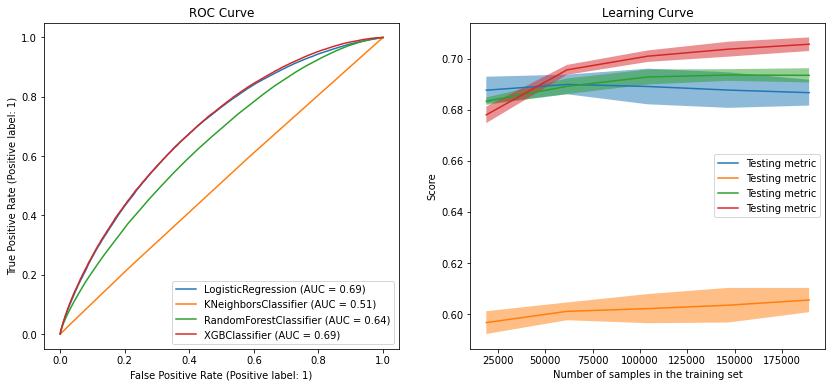

In [11]:
# plotting
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import LearningCurveDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
models = [log_clf, knn_clf, rf_clf, xgb_clf]
for model in models:
    model.fit(X_train_transfd, y_train)
    RocCurveDisplay.from_estimator(
        model, X_test_transfd, y_test,
        ax=ax[0]
        )
for model in models:
    LearningCurveDisplay.from_estimator(
        model, X_train_transfd, y_train,
        ax=ax[1], scoring=make_scorer(roc_auc_score, needs_proba=True),
        cv=StratifiedShuffleSplit(n_splits=5), 
        )
ax[0].set_title('ROC Curve')
ax[1].set_title('Learning Curve')

Left-hand plot shows *ROC* curve and *AUC* value for each model. The *AUC* is the calculated *Area Under the (ROC) Curve*. It can be seen that, model with higher AUC has steeper curve: the *TPR* is increasing faster at lower *FPR*. In other words, models with higher AUC can obtain higher *TPR* at lower cost.

*ROC* curves shows tradeoff between TPR and FPR along every possible categorizing *treshold* of probability that such observations is part of `Bad Loan` class:

$$\hat{f} < t\;then\;Good\;Loan$$
$$\hat{f}\geq t\;then\;Bad\;Loan$$

where $\hat{f}$ is the *decision function* and $t$ is the *treshold*. This explain the reason why the rightmost side of ROC has $TPR=1$ and $FPR=1$: all of the observations is labeled as *Bad Loan* by setting up the treshold value to the lowest possible *decision function* that obtained from the model.

So our strategy of model selection and optimization is clear: look for model with the best AUC, then we adjust the treshold so that, based on our dataset, maximize the profit (simultaneously minimize the potential loss).

Right-hand plot shows cross-validated learning curve for three of the models. Although we use training set, cross-validation can be used to estimate test result. The error band explains the *standard deviation* of score. We will use *GradientBoosting* since it shows promising performance. 

In [14]:
# df to plot
def plot_importance(fitted_model):
    feature_importances = fitted_model.feature_importances_.reshape(-1, 1)
    feature_names = fitted_model.feature_names_in_.reshape(-1, 1)
    importance_df = pd.DataFrame(
        np.c_[feature_names, feature_importances], 
        columns=['feature_name', 'importance'])
    importance_df = importance_df.assign(
        feature_name=importance_df.feature_name.str.split('__', n=1, expand=True).loc[:, 1],
        importance=importance_df.importance.astype('float64')
        ).sort_values('importance', ascending=False)
    # plot
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.barplot(x='importance', y='feature_name', data=importance_df.iloc[:20, :], ax=ax, color=sns.color_palette()[0])
    for y_, x_ in enumerate(importance_df.iloc[:20, :].importance.values):
        ax.text(
            x=(x_ + 0.001), 
            y=y_, s=f'{x_:,.3f}',
            verticalalignment='center'
            )
    ax.set_title(f'Feature Importance, {fitted_model.__class__.__name__}')

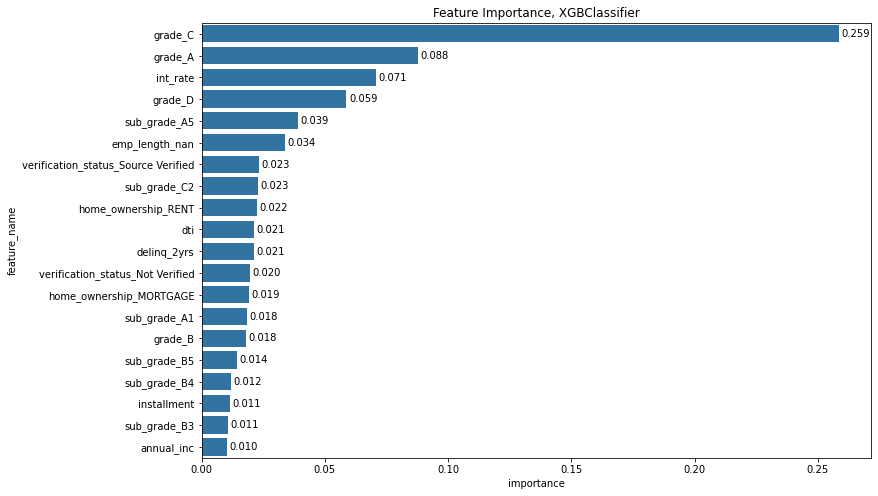

In [13]:
xgb_clf.fit(X_train_transfd, y_train)
plot_importance(xgb_clf)

Above plot explains the importance of each features, which is the contribution of each features in the input when training from the data. 

Features related with *grades* dominates the result but in a less intuitive way. However, we know from previous section that lower grade is associated with lower quality loans. It is also interesting to note that `Grade C` has the most counts of `Bad Loan` (see previous chapter). So, in my opinion, if the importance is high because of this association, the model won't fit well with independent data.

<a id="5-fature-engineering"> </a>
## 5. Feature Engineering

#### **Feature Transformation**

D:\anaconda3\envs\general_ds\lib\site-packages\IPython\core\pylabtools.py:137: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


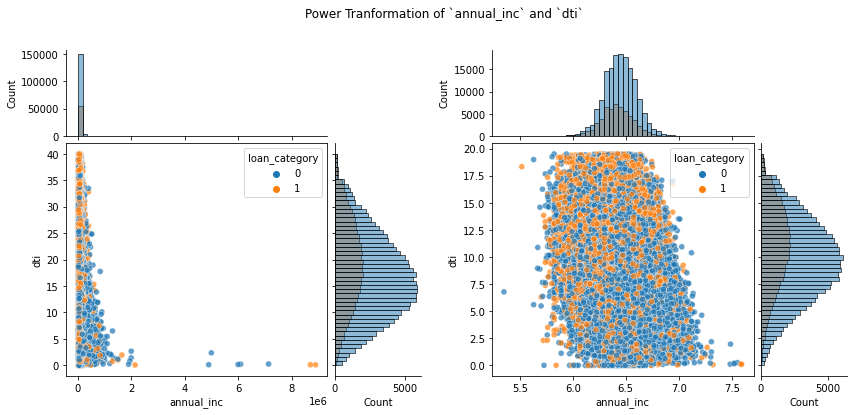

In [10]:
from sklearn.preprocessing import PowerTransformer
from mpl_toolkits.axes_grid1 import make_axes_locatable

labels = pd.DataFrame(y_train, columns=['loan_category'])
transformer_scaler = PowerTransformer(standardize=False).set_output(transform='pandas')
train_set_ = X_train[['annual_inc', 'dti']]
train_set_transfd = transformer_scaler.fit_transform(train_set_)
# merge with label
train_set_ = pd.merge(
    train_set_, labels, left_index=True, right_index=True
    )
train_set_transfd = pd.merge(
    train_set_transfd, labels, left_index=True, right_index=True
    )
# plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for idx, dataset in enumerate([train_set_, train_set_transfd]):
    divider = make_axes_locatable(ax[idx])
    ax_histx = divider.append_axes('top', 1.2, pad=0.1, sharex=ax[idx])
    ax_histx.xaxis.set_tick_params(labelbottom=False)
    sns.histplot(data=dataset, x='annual_inc', ax=ax_histx, hue='loan_category', bins=50, legend=False)
    ax_histx.spines['right'].set_visible(False)
    ax_histx.spines['top'].set_visible(False)
    ax_histy = divider.append_axes('right', 1.2, pad=0.1, sharey=ax[idx])
    ax_histy.yaxis.set_tick_params(labelleft=False)
    sns.histplot(data=dataset, y='dti', ax=ax_histy, hue='loan_category', bins=50, legend=False)
    ax_histy.spines['right'].set_visible(False)
    ax_histy.spines['top'].set_visible(False)
    sns.scatterplot(data=dataset, x='annual_inc', y='dti', hue='loan_category', ax=ax[idx], alpha=0.7)
fig.suptitle('Power Tranformation of `annual_inc` and `dti`')
plt.show()

Plot above shows an example of power transformation using `PowerTransformer (yeo-johnson)`. See how outliers handled without explicitly removing them: by "compressing" the distribution, differences between large values become smaller hence the heavy influence may be suppressed. The data become more balanced in the hope of mitigate outliers impact.

> In a very skewed dataset like this, the outliers must be treated carefully and the impact shall be analyzed further. Simply removing them may influence the analysis, what if the evidence reflects the nature of the population? Subject-matter-expect, helped with more sophisticated method may still be required, but the computation cost is of course more expensive.



#### **Extracting Post-Originated Features**

From previous chapter, we observed a pattern of `average portion paid` of bad loan which is associated according to its categorized loan `grade`. We will implement this extraction as below:

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

class LoanFeatureExtract(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y):
        X = X.assign(
            portion_paid=lambda x: x.total_rec_prncp / x.loan_amnt
            )
        bad_loan_mask = np.where(y == 'Bad Loan')[0]
        map_loan_cat = {'Good Loan': 0, 'Bad Loan': 1}
        self.avg_defaulted_recovery_ = X.iloc[bad_loan_mask, :]\
            .groupby('sub_grade')\
            .aggregate(avg_defaulted_recovery=pd.NamedAgg(column='portion_paid', aggfunc='mean'))\
            .reset_index()
        self.portion_defaulted_ = \
            pd.merge(X[['sub_grade']], 
                     pd.DataFrame(y, columns=['loan_category']).apply(lambda x: x.map(map_loan_cat)), 
                     left_index=True, right_index=True)\
                .groupby('sub_grade')\
                .aggregate(avg_portion_defaulted=pd.NamedAgg(column='loan_category', aggfunc='mean'))\
                .reset_index()
        return self

    def transform(self, X, y=None):
        X = pd.merge(
            X, self.avg_defaulted_recovery_, how='left', on='sub_grade'
            )
        X = pd.merge(
            X, self.portion_defaulted_, how='left', on='sub_grade'
            )
        X = X.drop(columns=['total_rec_prncp'])
        return X

Notice that `avg_defaulted_recovery_` (and others) is served as *fitted attribute* of this transformer  . The advantage of creating this transformer is to assure that there won't be data leakage from `test set`, since the `self.avg_defaulted_recovery_` is only updated using `fit` method (refer to *scikit-learn* documentation on how this attribute won't be updated by `transform` method).

In above extraction, we try to increases the dataset knowledge regarding the `Bad Loan`.

In [12]:
dataset_preprocess = Pipeline([
    ('preprocess', LoanDataPreprocess()),
    ('extract_label_predictor', LoanDataLabelPredictor(exclude=['earliest_cr_line', 'pymnt_plan', 'policy_code'], 
                                                       include=['total_rec_prncp'])),
    ('missing_handler', LoanDataMissingHandler()),
    ])

X_train, y_train = dataset_preprocess.fit_transform(train_set)
extract_feature = LoanFeatureExtract()
extract_feature.fit_transform(X_train, y_train).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,210369,210370,210371,210372,210373,210374,210375,210376,210377,210378,210379,210380,210381,210382,210383,210384,210385,210386,210387,210388,210389,210390,210391,210392,210393,210394,210395,210396,210397,210398,210399,210400,210401,210402,210403,210404,210405
emp_length,more 10 years,more 10 years,5 years,more 10 years,2 years,4 years,more 10 years,2 years,more 10 years,more 10 years,4 years,more 10 years,5 years,9 years,less 1 year,less 1 year,8 years,2 years,more 10 years,1 year,more 10 years,5 years,2 years,more 10 years,less 1 year,3 years,7 years,more 10 years,more 10 years,5 years,more 10 years,1 year,8 years,3 years,7 years,more 10 years,more 10 years,...,1 year,3 years,more 10 years,more 10 years,NaN,3 years,4 years,more 10 years,1 year,6 years,2 years,4 years,less 1 year,5 years,5 years,less 1 year,more 10 years,more 10 years,more 10 years,more 10 years,5 years,3 years,8 years,9 years,NaN,2 years,5 years,6 years,NaN,3 years,4 years,more 10 years,more 10 years,less 1 year,2 years,more 10 years,NaN
home_ownership,RENT,RENT,MORTGAGE,MORTGAGE,MORTGAGE,RENT,RENT,MORTGAGE,RENT,MORTGAGE,OWN,MORTGAGE,RENT,OWN,RENT,MORTGAGE,RENT,RENT,MORTGAGE,MORTGAGE,MORTGAGE,MORTGAGE,MORTGAGE,OWN,MORTGAGE,RENT,RENT,MORTGAGE,MORTGAGE,MORTGAGE,MORTGAGE,RENT,RENT,RENT,MORTGAGE,MORTGAGE,OWN,...,RENT,MORTGAGE,MORTGAGE,OWN,MORTGAGE,RENT,MORTGAGE,MORTGAGE,RENT,MORTGAGE,OWN,MORTGAGE,RENT,MORTGAGE,MORTGAGE,MORTGAGE,MORTGAGE,MORTGAGE,OWN,MORTGAGE,OWN,MORTGAGE,MORTGAGE,RENT,MORTGAGE,RENT,MORTGAGE,MORTGAGE,OWN,RENT,RENT,MORTGAGE,MORTGAGE,RENT,RENT,MORTGAGE,OWN
annual_inc,40000.00,25000.00,325000.00,100000.00,33000.00,32760.00,98000.00,39600.00,81500.00,41000.00,70000.00,80000.00,25000.00,45000.00,175000.00,112000.00,115000.00,60000.00,67000.00,70000.00,84000.00,50000.00,55000.00,41600.00,38000.00,60000.00,90000.00,74628.00,102120.00,90000.00,60000.00,38000.00,250000.00,50000.00,87500.00,56000.00,180000.00,...,35370.00,45000.00,40160.00,80000.00,40000.00,80000.00,262000.00,84000.00,65000.00,38000.00,27000.00,55000.00,60000.00,74000.00,57200.00,252000.00,76584.00,100000.00,62000.00,55000.00,35000.00,41000.00,98000.00,42000.00,47784.00,35000.00,69000.00,75000.00,49000.00,120000.00,42000.00,63078.00,48000.00,54000.00,27000.00,50000.00,32000.00
verification_status,Source Verified,Verified,Source Verified,Verified,Not Verified,Verified,Not Verified,Source Verified,Verified,Not Verified,Verified,Source Verified,Source Verified,Not Verified,Verified,Not Verified,Not Verified,Verified,Source Verified,Not Verified,Source Verified,Verified,Not Verified,Source Verified,Not Verified,Not Verified,Source Verified,Verified,Not Verified,Not Verified,Source Verified,Not Verified,Verified,Not Verified,Not Verified,Verified,Not Verified,...,Verified,Not Verified,Source Verified,Verified,Source Verified,Not Verified,Not Verified,Verified,Source Verified,Not Verified,Source Verified,Verified,Source Verified,Not Verified,Verified,Source Verified,Verified,Source Verified,Source Verified,Verified,Verified,Verified,Verified,Verified,Verified,Verified,Verified,Verified,Verified,Verified,Verified,Source Verified,Verified,Not Verified,Source Verified,Verified,Verified
dti,16.94,24.68,18.55,22.18,15.75,27.06,6.15,2.49,16.73,25.79,19.20,16.70,27.03,8.91,8.07,7.39,7.37,13.56,17.61,25.14,19.80,10.83,18.84,28.25,20.02,3.68,9.56,25.92,15.85,14.76,19.62,21.54,5.98,17.95,9.82,21.45,8.04,...,15.95,31.44,31.53,23.65,20.70,9.82,9.51,16.54,8.49,9.03,18.62,26.58,10.10,22.25,28.85,9.86,12.83,23.74,10.88,31.22,18.93,26.70,15.56,26.74,14.69,8.30,8.23,23.35,22.58,26.60,10.66,31.70,36.93,13.22,18.58,12.63,29.44
delinq_2yrs,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,1.00,2.00,0.00,0.00,0.00,...,0.00,4.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,2.00

We can confirm that there is no **post-originated loan data** in our transformer. Using this process, we can infer the future trends (based on our knowledge on available data) without leaking unknown data, mimics the real condition of future prediction.

#### **Combining into Pipeline**

Let's recap our model pipeline up to this section:

In [13]:
scale_cols = [
    'mths_since_last_delinq',
    'mths_since_last_record',
    'mths_since_last_major_derog',
    'mths_since_rcnt_il',
    'inq_last_6mths',
    'collections_12_mths_ex_med', 
    'acc_now_delinq', 'open_acc_6m', 
    'open_il_12m', 'open_il_24m',
    'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m',
    'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
    'max_bal_bc', 
    ]
categorical_cols = [
    'emp_length', 'home_ownership', 
    'verification_status', 'grade', 'sub_grade']
transform_cols = [
    'annual_inc', 'dti', 'delinq_2yrs', 
    'open_acc',
    'revol_bal', 'revol_util', 'total_acc',
    'tot_coll_amt', 'tot_cur_bal',
    'total_rev_hi_lim',  'pub_rec', 'int_rate',
    'installment', 'loan_amnt']
dataset_preprocess = Pipeline([
    ('preprocess', LoanDataPreprocess()),
    ('extract_label_predictor', LoanDataLabelPredictor(exclude=['earliest_cr_line', 'pymnt_plan', 'policy_code', 'term'], 
                                                       include=['total_rec_prncp'])),
    ('missing_handler', LoanDataMissingHandler()),
    ])
feature_modifier = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ('power', PowerTransformer(standardize=False), transform_cols),
    # ('discretize', RobustScaler(), scale_cols)
    ], remainder='passthrough').set_output(transform='pandas')
dataset_pipeline = Pipeline([
    ('feature_extract', LoanFeatureExtract()),
    ('feature_modifier', feature_modifier)
])

dataset_pipeline


Pipeline(steps=[('feature_extract', LoanFeatureExtract()),
                ('feature_modifier',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['emp_length',
                                                   'home_ownership',
                                                   'verification_status',
                                                   'grade', 'sub_grade']),
                                                 ('power',
                                                  PowerTransformer(standardize=False),
                                                  ['annual_inc', 'dti',
                                                   'delinq_2yrs', 'open_acc',
                                                   'revol_bal', 'revol_util',
                                                   'total_acc', 'tot_coll_amt',
                                                   'tot_cur_bal',
                                                   'total_rev_hi_lim',
                                                   'pub_rec', 'int_rate',
                                                   'installment',
                                                   'loan_amnt'])]))])

Now let's try our XGBoost model for any performance improvement.

In [14]:
# prepare the dataset
X_train, y_train = dataset_preprocess.fit_transform(train_set)
X_test, y_test = dataset_preprocess.transform(test_set)
X_train_transfd = dataset_pipeline.fit_transform(X_train, y_train)
X_test_transfd = dataset_pipeline.transform(X_test)
y_train = np.vectorize(map_array)(y_train)
y_test = np.vectorize(map_array)(y_test)
# prepare model
xgb_clf = XGBClassifier(
    max_depth=4, alpha=10, learning_rate=0.5, n_estimators=100,
    )
# initialize an empty list to store the scores
scoring_method = make_scorer(roc_auc_score, needs_proba=True) # returns callable in form of scorer(estimator, X, y)
cross_val_evaluation([xgb_clf], X_train_transfd, y_train, scoring_method)

XGBClassifier: Mean score = 0.71, Standard deviation = 0.00


Let's check feature importance and identify if any of our extracted feature is importance.

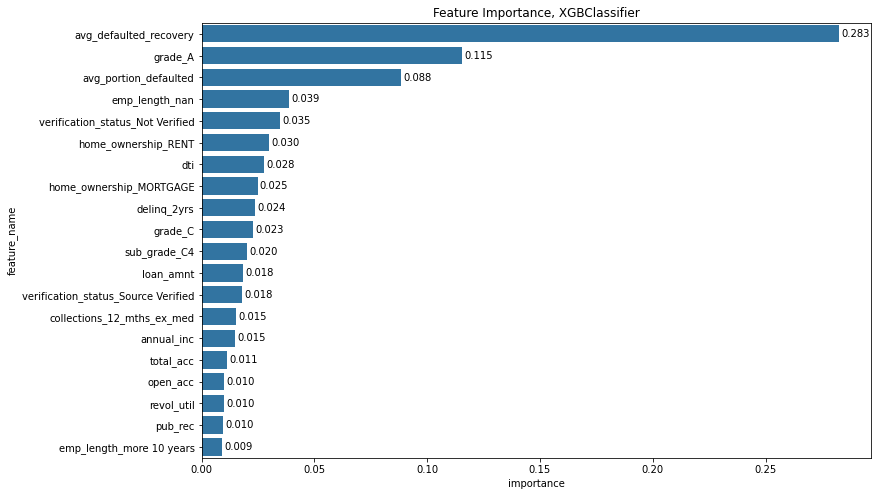

In [19]:
xgb_clf.fit(X_train_transfd, y_train)
plot_importance(xgb_clf)

It may be possible to perform a regression problem of `total_loan_recovery` and serve the regression results as a new predictor. This kind of imputation is expensive therefore not implemented in this analysis.

<a id="6-hyperparameter"> </a>
## 6. Hyperparameter Optimization

Let's first inspect how our boosting performs at each step to get a general idea of hyperparameter optimization strategy!

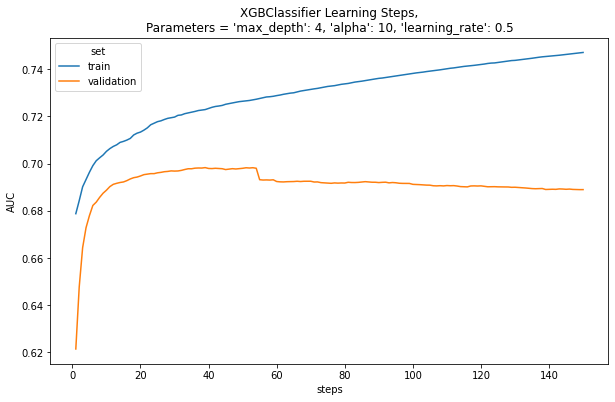

In [32]:
def plot_xgb_learning_step(
        X_train, y_train, X_valid, y_valid, 
        num_rounds=100, params={}):
    # boost element
    boost = None
    # classifier
    xgb = XGBClassifier(n_estimators=1, **params)
    # iteration records
    boost_step_no = []
    auc_train = []
    auc_val = []
    # iterate for each step
    def boost_step(steps):
        nonlocal xgb, boost, boost_step_no, auc_train, auc_val, X_train, y_train, X_valid, y_valid
        if steps == 0:
            boost = xgb.fit(X_train, y_train) # first step must be fitted
        else:
            boost = xgb.fit(X_train, y_train, xgb_model=boost) # use fitted boost step
        y_train_proba = boost.predict_proba(X_train)[:, 1]
        y_valid_proba = boost.predict_proba(X_valid)[:, 1]
        auc_train.append(roc_auc_score(y_train, y_train_proba))
        auc_val.append(roc_auc_score(y_valid, y_valid_proba)) 
        boost_step_no.append(i + 1)   
    for i in range(num_rounds):
        boost_step(i)
    #plot
    plot_df = pd.DataFrame(np.c_[boost_step_no, auc_train, auc_val], columns=['steps', 'train', 'validation'])
    plot_df = pd.melt(
        plot_df, id_vars=['steps'], value_vars=['train', 'validation'],
        var_name='set', value_name='AUC')
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.lineplot(data=plot_df, x='steps', y='AUC', hue='set', ax=ax)
    ax.set_title(f'{boost.__class__.__name__} Learning Steps,\nParameters = {str(params).strip("{}")}')
    
model_params = {
    'max_depth': 4, 
    'alpha': 10, 
    'learning_rate': 0.5,
    }
plot_xgb_learning_step(
    X_train_transfd, y_train, X_test_transfd, y_test, 
    num_rounds=150, params=model_params)

We can see the point that our model start overfitting the train set. We will implement `Early Stopping Callbacks` to get the where is the best round numbers of learning.

In [21]:
xgb_clf = XGBClassifier(
    max_depth=4, alpha=10, learning_rate=0.5, n_estimators=100,
    early_stopping_rounds=10, eval_metric='auc', # these are the callback parameter
    )
xgb_clf.fit(
    X_train_transfd, y_train,
    eval_set=[(X_test_transfd, y_test)], verbose=False)
print(f'XGBoostClassifier best scores (AUC, validation set): {xgb_clf.best_score:.3f} at {xgb_clf.best_iteration} iterations')

XGBoostClassifier best scores (AUC, validation set): 0.698 at 38 iterations


We can observe that the model converges rather fast, indicates that the learning rate may be too high hence consider to try lower learning rate.

> About *EarlyStopping* Callback
>
> Above code implements early stopping by defining `early_stopping_rounds` and `eval_metric` instantiation parameters, followed by `eval_set` in `fit` method. The most appropriate approach is to use a `validation set` independent of `test set`. 
>
>Furthermore, we can create a more flexible callback specification (for example: setting up the tolerance, return best model, etc.) by constructing `xgb.callback.EarlyStopping` object and pass it to the constructor. However, this is not needed in our case since we will wrap it into `Optuna` hyperparams optimization and the default callback params value is already appropriate. 

#### **Initial Hyperparameter Optimization**

Here I determine the hyperparameters to be optimized using `Optuna`:

In [22]:
import optuna 
import logging
from datetime import datetime

def objective(trial):
    params = {
        # learning parameter
        'n_estimators': 200, # if xgb.best_iter = 200 means that don't converge to minima yet
        'early_stopping_rounds': 30, # wait until 30 iterations
        'eval_metric': 'auc',
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'max_delta_step': trial.suggest_float('max_delta_step', 1, 10),
        'scale_pos_weight': trial.suggest_float('scale_post_weight', 1, 3), # intended to balance positive instance. 
                                                                            # remember that our training set proportion 
                                                                            # is 75% [0] - 25% [1]
        # tree complexity
        'max_depth': trial.suggest_int('max_depth', 1, 4), # [1, 4]
        'min_child_weight': trial.suggest_float('minimal_child_weight', 1, 10),
        'alpha': trial.suggest_float('alpha', 1, 10), # shrinkage
        'gamma': trial.suggest_float('gamma', 1, 10), # shrinkage
        }
    xgb_clf = XGBClassifier(**params)
    xgb_clf.fit(
        X_train_transfd, y_train,
        eval_set=[(X_test_transfd, y_test)], verbose=False)
    best_score = xgb_clf.best_score
    best_iteration = xgb_clf.best_iteration
    logging.info(
        f'XGBoostClassifier, trial {trial.number} best scores (AUC, validation set): '
        f'{best_score:.3f} at {best_iteration} iterations') # using this logging, we can identify if `num_of_iterations`
                                                            # is not enough for the `learning_rate` at specific trial
    return best_score

# setting up logging specification
current_date_time_ = datetime.now().strftime('%Y-%m-%d_%H-%M')
logging.basicConfig(
    filename=f'models/xgb_opt_log_{current_date_time_}.log',
    format='%(asctime)s - %(levelname)s: %(message)s',
    level=logging.INFO 
    )
optuna.logging.set_verbosity(30)
# setting up optuna
study = optuna.create_study(
    direction='maximize', sampler=optuna.samplers.TPESampler(seed=99)
    )
study.optimize(objective, n_trials=100)
# close logging file
logging.getLogger().handlers.clear()

In [24]:
# for model persistence
import pickle
import optuna

# serialize
# with open('models/initial_study.pkl', 'wb') as f:
#     pickle.dump(study, f)
# with open('models/initial_sampler.pkl', 'wb') as f:
#     pickle.dump(study.sampler, f)
# import serialized study
sampler = pickle.load(open('models\initial_sampler.pkl', 'rb'))
study = pickle.load(open('models\initial_study.pkl', 'rb'))

What have we done in above codes?

1. Optuna performs the optimization using `func` that returns the objective to be maximized. From previous section, we already know how to get the best score by utilizing XGBClassifier `early_stopping` callback. We set the `.best_score` attribute as the objective and set the study's `direction` to `maximize`.

2. We set possible hyperparams to be optimized inside the `objective` func. Since the params are rather too many, we can identify which one is significance to be adjusted by inspecting the `importance` of each hyperparams and perform re-optimization with selected params and narrowed range (*zooming in*) if deemed necessary.

3. `logging` provides a better inspection for each of the iteration. Notice on how I limit `num_of_rounds` to `200` (to minimize computation cost). On smaller learning rate, the model may not converged yet and we can identify it by inspecting the [log file](models\xgb_opt_log_2023-01-26_10-58.log). If the iterations valued at around `200`, this will shows `num_of_rounds` is too small and `AUC` may be improved for larger `num_of_rounds`.

4. We choose `TPE` as the sampling algorithm since it performance is known to be robust for small iterations. Number of `n_trials = 100` is the minimum recommended sample size (refer to Optuna documentaries). We use `LogUniform` distribution focusing on exponentially sampling (e.g. `0.1`, `0.01`, `0.001`). For large range hyperparameter space, we will analyze the *parallel coordinate plot* to identify possible best narrower range, and will consider for *zooming in* optimization.

Let's see the best results:

In [25]:
def create_df_from_study(study_, log_file_dir):
    # reading log files
    xgb_log = open(log_file_dir, 'r').readlines()
    xgb_log_df = pd.DataFrame(xgb_log, columns=['log'])
    xgb_iters = xgb_log_df\
        .log.str.split(' ', expand=True)\
        .loc[:, [6, 14]]\
        .rename(columns={6: 'number', 14: 'xgb_iters'})\
        .assign(
            number=lambda x: x.number.astype('int64'),
            xgb_iters=lambda x: x.xgb_iters.astype('int64'))
    # export study results to DataFrame
    study_results_df = study_.trials_dataframe()
    # study_results_df = study_results_df.dropna().assign(
    #     xgb_iters=xgb_iters.astype('int64')
    #     )
    study_results_df = pd.merge(
        study_results_df, xgb_iters, on='number'
        )
    return study_results_df

# reading log files
study_results = create_df_from_study(study, 'models\\xgb_opt_log_2023-01-26_10-58.log')
study_results.sort_values(by='value', ascending=False).head(1).T

,11
number,11
value,0.70
datetime_start,2023-01-26 12:39:36.501800
datetime_complete,2023-01-26 12:41:46.919822
duration,0 days 00:02:10.418022
params_alpha,5.39
params_gamma,3.31
params_learning_rate,0.09
params_max_delta_step,7.63
params_max_depth,3


#### **Analyzing Optimization Results**

Let's first analyze score growth during each trials:

Text(0.5, 1.0, 'Number of XGB Iterations')

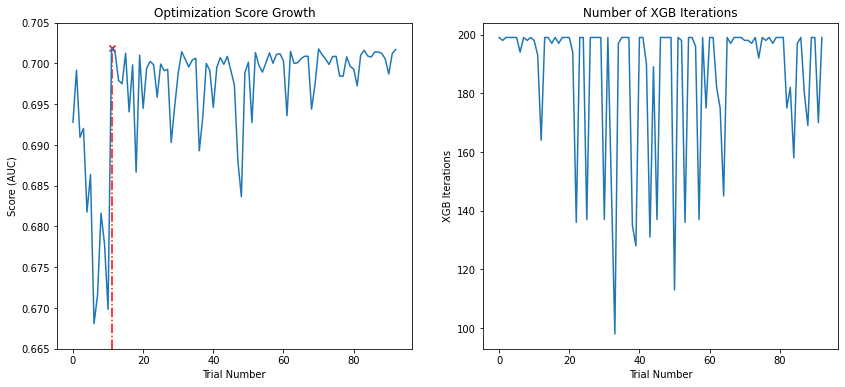

In [25]:
# plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
max_point = study_results.loc[study_results.value == study_results.value.max(), ['number', 'value']].values[0]
sns.lineplot(data=study_results, x='number', y='value', ax=ax[0])
sns.lineplot(data=study_results, x='number', y='xgb_iters', ax=ax[1])
ax[0].scatter(x=[max_point[0]], y=[max_point[1]], marker='x', color='red')
yticks = ax[0].get_yticks()
ax[0].vlines(x=[max_point[0]], ymin=0, ymax=[max_point[1]], colors='red', ls='-.')
ax[0].set_ylim(yticks[0], yticks[-1])
ax[0].set_xlabel('Trial Number')
ax[0].set_ylabel('Score (AUC)')
ax[0].set_title('Optimization Score Growth')
ax[1].set_xlabel('Trial Number')
ax[1].set_ylabel('XGB Iterations')
ax[1].set_title('Number of XGB Iterations')

Looks like our optimizer is by XGB iteration limits of 200. Perhaps we shall increase our XGB iterations limit. Indeed it will increase the computation cost.

Let's look at parameter importance:

Text(0.5, 1.0, 'Hyperparameter Importances')

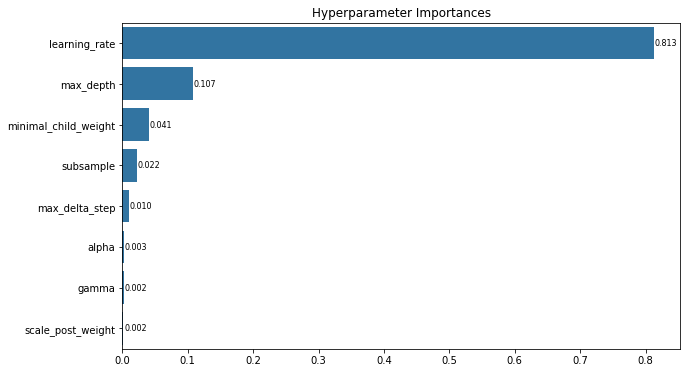

In [26]:
import optuna

param_importances = optuna.importance.get_param_importances(study)
importance_values = np.array(list(param_importances.values()))
param_names = np.array(list(param_importances.keys()))
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=importance_values, y=param_names, ax=ax, color=sns.color_palette()[0])
for y_, x_ in enumerate(importance_values):
    ax.text(
        x=(x_ + 0.001), 
        y=y_, s=f'{x_:,.3f}',
        verticalalignment='center', size=8
        )
ax.set_title('Hyperparameter Importances')

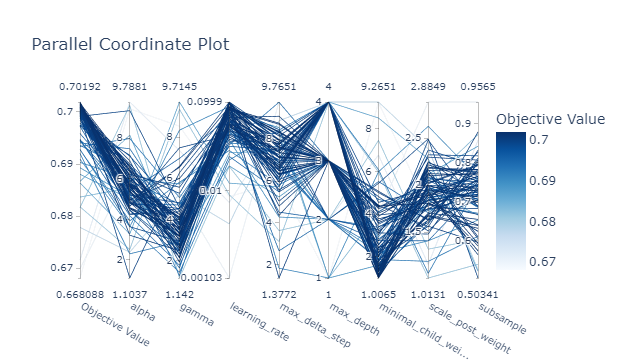

In [27]:
from optuna.visualization import plot_parallel_coordinate

plot_parallel_coordinate(study)

Parallel coordinate plots, in my opinion, is one of the most informative plot for hyperparameter tuning. 

- As we can see, perhaps the learning rate is capped at 0.1 which optimizer try to break through (recall we set the distribution at `[0.001, 0.1]`)
- Bi-modal tendencies of `max_depth`. We should consider increasing the cap
- Optimizer seems to go lower on `minimal_child_weight`

#### **Zooming the Hyperparameters**

Based on previous analysis, we observed that our learning rate still needs to be adjusted and the `max_iter` is too low. Some of the parameter need to be re-optimized. So we will re-optimize the parameters as below:

In [28]:
import optuna 
import logging
from datetime import datetime

def objective(trial):
    params = {
        # learning parameter
        'n_estimators': 400, # if xgb.best_iter = 200 means that don't converge to minima yet
        'early_stopping_rounds': 50, # wait until 50 iterations
        'eval_metric': 'auc',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1, log=True),
        'subsample': trial.suggest_float('subsample', 0.7, 0.8),
        'max_delta_step': trial.suggest_float('max_delta_step', 4, 9),
        'scale_pos_weight': trial.suggest_float('scale_post_weight', 1.5, 2.5), # intended to balance positive instance. 
                                                                                # remember that our training set proportion 
                                                                                # is 75% [0] - 25% [1]
        # tree complexity
        'max_depth': trial.suggest_int('max_depth', 3, 6), # [1, 4]
        'min_child_weight': trial.suggest_float('minimal_child_weight', 1, 10),
        'alpha': trial.suggest_float('alpha', 4, 8), # shrinkage
        'gamma': trial.suggest_float('gamma', 2, 5), # shrinkage
        }
    xgb_clf = XGBClassifier(**params)
    xgb_clf.fit(
        X_train_transfd, y_train,
        eval_set=[(X_test_transfd, y_test)], verbose=False)
    best_score = xgb_clf.best_score
    best_iteration = xgb_clf.best_iteration
    logging.info(
        f'XGBoostClassifier, trial {trial.number} best scores (AUC, validation set): '
        f'{best_score:.3f} at {best_iteration} iterations') # using this logging, we can identify if `num_of_iterations`
                                                            # is not enough for the `learning_rate` at specific trial
    return best_score

# setting up logging specification
current_date_time_ = datetime.now().strftime('%Y-%m-%d_%H-%M')
logging.basicConfig(
    filename=f'models/xgb_opt_log_{current_date_time_}.log',
    format='%(asctime)s - %(levelname)s: %(message)s',
    level=logging.INFO 
    )
optuna.logging.set_verbosity(30)
# setting up optuna
re_study = optuna.create_study(
    direction='maximize', sampler=optuna.samplers.TPESampler(seed=99)
    )
re_study.optimize(objective, n_trials=100)
# close logging file
logging.getLogger().handlers.clear()

In [20]:
# for model persistence
import pickle
import optuna

# serialize
# with open('models/re_study_1.pkl', 'wb') as f:
#     pickle.dump(re_study, f)
# with open('models/re_study_1_sampler.pkl', 'wb') as f:
#     pickle.dump(re_study.sampler, f)
# import serialized study
re_study_sampler = pickle.load(open('models\\re_study_1_sampler.pkl', 'rb'))
re_study = pickle.load(open('models\\re_study_1.pkl', 'rb'))

Comparing to previous optimization:

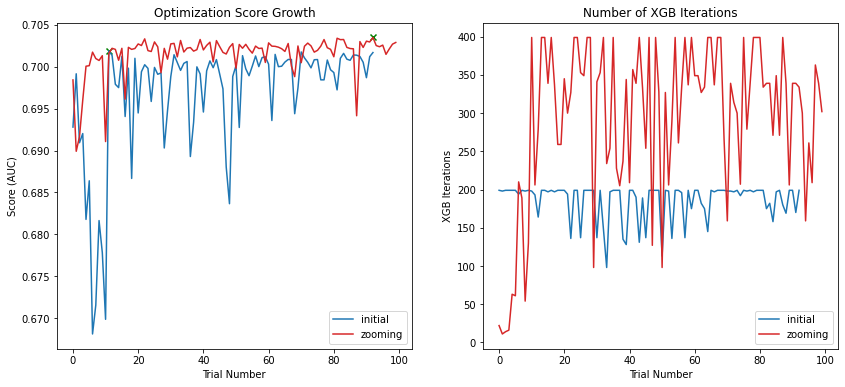

In [33]:
# create dataframe
re_study_results = create_df_from_study(re_study, 'models\\xgb_opt_log_2023-01-26_18-27.log')
# plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
max_point_study_1 = study_results.loc[study_results.value == study_results.value.max(), ['number', 'value']].values[0]
max_point_study_2 = re_study_results.loc[re_study_results.value == re_study_results.value.max(), ['number', 'value']].values[0]
sns.lineplot(data=study_results, x='number', y='value', ax=ax[0], color='#1f77b4', label='initial')
sns.lineplot(data=study_results, x='number', y='xgb_iters', ax=ax[1], color='#1f77b4', label='initial')
sns.lineplot(data=re_study_results, x='number', y='value', color='#d62728', ax=ax[0], label='zooming')
sns.lineplot(data=re_study_results, x='number', y='xgb_iters', color='#d62728', ax=ax[1], label='zooming')
ax[0].scatter(x=[max_point_study_1[0]], y=[max_point_study_1[1]], marker='x', color='green')
ax[0].scatter(x=[max_point_study_2[0]], y=[max_point_study_2[1]], marker='x', color='green')
ax[0].set_xlabel('Trial Number')
ax[0].set_ylabel('Score (AUC)')
ax[0].set_title('Optimization Score Growth')
ax[1].set_xlabel('Trial Number')
ax[1].set_ylabel('XGB Iterations')
ax[1].set_title('Number of XGB Iterations')
plt.legend()
plt.show()

Indeed we can observe slight performance improvement after the zooming process. The zooming process proven to be useful and at a correct path. Let's take a look at tendencies of our algorithm optimization process of selecting the best hyperparams:


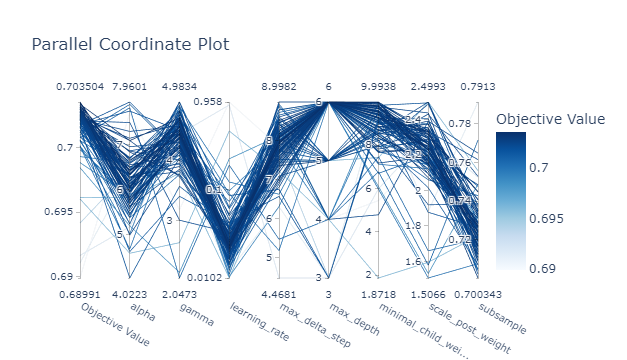

In [31]:
plot_parallel_coordinate(re_study)

Looks like `max_depth` can be a little higher. Further we can improve the model by fixing most of the least importances params and focuses more on `max_depth` and `learning_rate`.

For now, let's conclude our hyperparameter optimization by these best parameters returned.

In [28]:
best_params = re_study.best_params
best_params['scale_pos_weight'] = best_params['scale_post_weight']
best_params['min_child_weight'] = best_params['minimal_child_weight']
del best_params['scale_post_weight']
del best_params['minimal_child_weight']
final_classifier = XGBClassifier(n_estimators=334, **best_params)
final_classifier.fit(X_train_transfd, y_train,verbose=False)

re_study_results.sort_values(by='value', ascending=False).head(1).T

,92
number,92
value,0.70
datetime_start,2023-01-27 02:22:43.314071
datetime_complete,2023-01-27 02:29:17.155771
duration,0 days 00:06:33.841700
params_alpha,6.33
params_gamma,4.68
params_learning_rate,0.03
params_max_delta_step,7.97
params_max_depth,6


<a id="7-model-implementation"> </a>
## 7. Model Implementation: Selecting Profitable Loan

I will demonstrate implementation of our prediction model to solve a simple problem: among available loan with specific profile, which loans that will be potential to generate profit and which is possibly defaulted so we can avoid loss.

This chapter focuses on developing `Loan Selector`, a simple algorithm to select possibly profitable loan. We will compare several loan selectors based on its particular selecting method and decide which selector has the best performance. Note that this is for demonstration only.

<a id="7.1-preparation"> </a>
### 7.1. Preparation

#### **Strategy**

We will consider 4 methods of selecting profitable loan that can measure if our model can be advantageous and reliable to maximize investment return.

1. `Selector A`: We choose most of the available loan to be invested as possible. This serves as `non-informed` decision (generous investor).
2. `Selector B`: We choose only possibly 'good loan'. I determine 'possibly good loan' is the loan graded `A` or `B` (subjective!). This serves as `minimal-informed` decision.
3. `Selector C`: Utilizing model's probability of prediction. We select the potential loan which have value (see previous chapter): $P(loan=Good\;Loan)\times\;Return\;Ratio>1$ , some sort of calculating the *expectancy* of loan will profit.
4. `Selector D`: Also utilizing model's probability of prediction. But this time, we adjust the treshold of probability prediction as a filter for selecting loan.

So, how to do the testing? We will try to simulate the real condition: opening the LendingClub website and inspect open loan that currently available. Therefore the simulations should be: 

1. We will do sampling by drawing observations multiple times (with replacement) from test set (including only finished loan). Further question: how many observations per sample?
2. Calculate the profit of each sample. Then we will calculate `mean` and `deviation` for each `selector`.

Then, how many observations for each sample? Remember, from previous chapter, there exist `Issued` loan category at train set (unfortunately none available at test set). Assumming the records is collected by the end of the data record, let's inspect number of `Issued` loan by the end periods!

In [36]:
from modules.data_preprocess import LoanDataPreprocess

train_set_observe = LoanDataPreprocess().fit_transform(train_set)
train_set_observe\
    .set_index('issue_d')\
    .loc[lambda x: x.loan_status == 'Issued', :]\
    .groupby(pd.Grouper(freq='1M'))\
    .agg(count_available_loan=pd.NamedAgg(column='loan_status', aggfunc='count'))
    

,count_available_loan
issue_d,
2015-12-31,8460


Let's consider `300` of loans for our simulation (due to limitation of test set and to reduce solving difficulty).

> Note: performing statistical test may deemed appropriate in determining sample size for simulation

Too make the case more interesting, let's limit the value of total investment to just `$100,000` (consider this as an investment budget) and find which method make the most profits!

#### **Preparing the Data**

Now we focus more on test dataset: Loan Dataset of 2016 - 2017. We will use our previous `dataset_preprocess` pipeline to subset the valid loan. However, we will include post-originated loan data: `funded_amnt_inv` and `total_pyment_inv`.

We will asert if the testing dataset (for profit) is match with `X_test`.

In [37]:
testing_dataset_pipeline = Pipeline([
    ('preprocess', LoanDataPreprocess()),
    ('extract_label_predictor', LoanDataLabelPredictor(exclude=['earliest_cr_line', 'pymnt_plan', 'policy_code'], 
                                                       include=['total_rec_prncp', 'funded_amnt_inv', 'total_pymnt_inv',
                                                                'total_rec_int', 'total_rec_late_fee', 'recoveries',
                                                                'collection_recovery_fee', 'out_prncp_inv', 'funded_amnt', 
                                                                'total_pymnt'])),
    ('missing_handler', LoanDataMissingHandler()),
    ])

testing_df, testing_label = testing_dataset_pipeline.fit_transform(test_set)
assert X_test.shape[0] == testing_df.shape[0]

No `AssertionError` raised. Furthermore, we can assure that each of the observations match with testing dataset.

In [35]:
assert np.mean(X_test.loan_amnt == testing_df.loan_amnt) == 1

All of the records match! For simplicity, we just merge the probability prediction of the model to the `testing_df`. So our testing dataframe should contain:

1. `loan_amnt`, the amount of loan that has been funded
2. `total_pymnt`, the amount of payment that obtained, including principal payment, interest payment, late fee, and recoveries (for defaulted loan)
3. `actual_return`, is calculated as `total_pymnt` - `loan_amnt`.
4. `probability_bad_loan`, is the result of our classification model.

In [38]:
testing_df = testing_df\
    .assign(
        proba_bad_loan=final_classifier.predict_proba(X_test_transfd)[:, 1],
        potential_return=lambda x: x.loan_amnt * x.int_rate / 100,
        actual_return=lambda x: x.total_pymnt - x.loan_amnt)\
    .loc[:, ['loan_amnt', 'int_rate', 'grade', 'potential_return', 'actual_return', 'proba_bad_loan']]

testing_df.head()

,loan_amnt,int_rate,grade,potential_return,actual_return,proba_bad_loan
0,11575.00,7.35,A,850.76,132.82,0.19
1,7200.00,24.85,E,1789.20,6.46,0.73
2,7500.00,7.35,A,551.25,142.29,0.17
3,10000.00,16.02,C,1602.00,26.70,0.44
4,14000.00,16.02,C,2242.80,375.14,0.42


Finally, `Selector C` and `Selector D` will be involved in optimization algorithm. So we want to split that set to have isolated `validation_set`.

In [39]:
from sklearn.model_selection import train_test_split

testing_df_test, testing_df_valid = train_test_split(testing_df, test_size=0.1, stratify=y_test, random_state=5555)

<a id="7.2-develop-selectors"> </a>
### 7.2. Develop the `Selectors` and Optimization Process

#### **Knapsack Problem and Solving using *Pyomo***

Selecting the most profitable loan in a specific budget limit is an example of *knapsack* problem: we select loans with specific price and value to include in the combination so that the total value is as large as possible while keeping the total price under the constraint. 

To correlate this concept with our problem: Given a set of $n$ available loan (in our case, $n=500$), each particular loan indices ($i$) has a price $w_i$ and a value $v_i$: our action is to buy that particular loan ($w_i\times\;1$) or ignore the loan ($w_i\times\;0$) so that we can

$$maximize:\;\sum_{
    \begin{subarray}{l}1\leq\;i\leq\;n\end{subarray}
}v_ix_i$$
$$x_i\in\;(0,\;1)$$

While keeping the total price $W$ under the budget constraint. So our maximization problem

$$subject\;to:\;\sum_{
    \begin{subarray}{l}1\leq\;i\leq\;n\end{subarray}
}w_ix_i\leq\;W$$

The value $v_i$ is specific for each of our `Selector`, explained shortly.

Code below provides a function that solve our knapsack problem to return the loan indices $i$: $f(v_i,\;w_i,\;W)\rightarrow\;\set{i}\;which\;maximize\;(\sum_{
    \begin{subarray}{l}1\leq\;i\leq\;n\end{subarray}
}v_ix_i)$. 

In linear programming terms, knapsack problem is categorized as *Mixed Integer Linear Programming* (MILP). We shall choose appropriate solver that can tackle MILP, so I choose [SCIP](https://scipopt.org). We will use `pyomo` API to instantiate the solver:

In [41]:
import pyomo.environ as pyo

def get_loan_choice(value, weight, constraint):
    """
    Parameters
    ----------
    value: ArrayLike with shape (n, )
    weight: ArrayLike with shape (n, )
    constraint: Scalar
     """
    def obj_rule(model_):
        return sum(model_.v[i] * model_.x[i] for i in model_.i)

    def const_rule(model_):
        return (sum(model_.w[i] * model_.x[i] for i in model_.i) <= model.W)

    n = len(value)
    i_ = np.arange(n)
    value_map = dict(zip(i_, value))   # need to create dictionary
    weight_map = dict(zip(i_, weight)) # this is due to pyomo structure is dict-like
    # pyo model
    model = pyo.ConcreteModel()
    model.i = pyo.RangeSet(0, (n - 1)) # indexing object. Refer to our formula, we only need `i` for indexing
    model.v = pyo.Param(model.i, initialize=value_map, within=pyo.NonNegativeReals) #.Param object is fixed value
    model.w = pyo.Param(model.i, initialize=weight_map, within=pyo.NonNegativeReals)
    model.x = pyo.Var(model.i, within=pyo.NonNegativeIntegers, bounds=(0, 1)) #.Var object is value to be obtained by optimizing
    model.W = pyo.Param(initialize=constraint) # Scalar Constraint
    model.OBJ = pyo.Objective(rule=obj_rule, sense=pyo.maximize) # we only need 1 coonstraint
    model.CONST = pyo.Constraint(rule=const_rule) # we need only 1 constraint
    # start the solver
    opt = pyo.SolverFactory('scip', solver_io='nl')
    opt.solve(model)
    loan_mask = [v_() for v_ in model.x.values()] # after optimization is completed, just access the model.x values.
    selected_loan_idx = i_[np.argwhere(loan_mask)].flatten()
    # return the index of loan to buy
    return selected_loan_idx

Notice carefully about each of the model attribute. We specified indexing `i` (`model.i`) for variables  so that those attributes created as `pyo.IndexedParam` (by passing `model.i` at the first arguments to reflect $v_i$, $w_i$, $x_i$). However, `model.i` is not passed to `model.W` since it must be a `Scalar` variable.

#### **Selector A**

For `Selector A`, we just need to find combination of loans (for each sample) which sum of the `loan_amnt` ($W$) is the nearest to our budget constraint (`$100,000`), with *value* ($v_i$) of the loan is simply the potential loan profit (tagged as `potential_return`).

In [42]:
def SelectorA(budget, df, return_total_funding=False):
    # input
    value = df.potential_return.values
    weight = df.loan_amnt.values
    actual_return = df.actual_return.values
    W = budget
    # output
    loan_idx = get_loan_choice(value, weight, W)
    # summary
    net_return = actual_return[loan_idx].sum()
    total_funding = weight[loan_idx].sum()
    if return_total_funding:
        return net_return, total_funding
    return net_return

sample_df = testing_df_test.sample(300)
net_return, total_funding = SelectorA(100000, sample_df, True)
print(f'Selector A. Total funding = ${total_funding:,.0f}, return = ${net_return:,.0f}')

Selector A. Total funding = $99,850, return = $-33,490


#### **Selector B**

`Selector B` is rather similar to `Selector A`, but before we pick the combinations, we must filter the dataframe to only include `Grade A` and `Grade B` loan.

In [43]:
def SelectorB(budget, df, return_total_funding=False):
    subset_df = df[df.grade.isin(['A', 'B'])]
    # input
    value = subset_df.potential_return.values
    weight = subset_df.loan_amnt.values
    actual_return = subset_df.actual_return.values
    W = budget
    # output
    loan_idx = get_loan_choice(value, weight, W)
    # summary
    net_return = actual_return[loan_idx].sum()
    total_funding = weight[loan_idx].sum()
    if return_total_funding:
        return net_return, total_funding
    return net_return

sample_df = testing_df_test.sample(200)
net_return, total_funding = SelectorB(100000, sample_df, True)
print(f'Selector B. Total funding = ${total_funding:,.0f}, return = ${net_return:,.0f}')

Selector B. Total funding = $100,000, return = $-1,252


#### **Selector C**

Recall from previous section, `Selector C` calculate the ratio of valuable loan:

$$P(loan=Good\;Loan)\times\;Return\;Ratio>1$$

Some other may include *risk-free rate* in the right side of the equation, which is the rate of return that an investor can expect to earn on an invesment that carries no risk of default. Because, why bother investing in a loan that have lower (expected) return than investment with exact return. 

In [44]:
def SelectorC(budget, df, return_total_funding=False):
    # input
    subset_df = df.assign(
        value_ratio = (1 - df.proba_bad_loan) * (1 + df.int_rate / 100)
        )
    subset_df = subset_df[subset_df.value_ratio > 1]
    if len(subset_df) == 0:
        if return_total_funding:
            return 0, 0
        return 0
    value = subset_df.value_ratio.values
    weight = subset_df.loan_amnt.values
    actual_return = subset_df.actual_return.values
    W = budget
    # output
    loan_idx = get_loan_choice(value, weight, W)
    # summary
    net_return = actual_return[loan_idx].sum()
    total_funding = weight[loan_idx].sum()
    if return_total_funding:
        return net_return, total_funding
    return net_return

sample_df = testing_df_test.sample(200)
net_return, total_funding = SelectorC(100000, sample_df, True)
print(f'Selector C. Total funding = ${total_funding:,.0f}, return = ${net_return:,.0f}')

Selector C. Total funding = $0, return = $0


#### **Selector D**

For our final `Selector`, we adjust the treshold of probability to filter which loan we will choose. We will find the best value of threshold for our condition, again by using `optuna`. Later, recall the *TPR* and *FPR*, we will analyze our choice of treshold.

In [45]:
def SelectorD(budget, df, return_total_funding=False, treshold=0.5, value_choice='potential_return'):
    # input
    subset_df = df[df.proba_bad_loan < treshold]
    if len(subset_df) == 0:
        if return_total_funding:
            return 0, 0
        return 0
    if value_choice == 'proba_bad_loan':
        value = (1 - subset_df.proba_bad_loan).values
    elif value_choice == 'potential_return':
        value = subset_df.potential_return.values
    weight = subset_df.loan_amnt.values
    actual_return = subset_df.actual_return.values
    W = budget
    # output
    loan_idx = get_loan_choice(value, weight, W)
    # summary
    net_return = actual_return[loan_idx].sum()
    total_funding = weight[loan_idx].sum()
    if return_total_funding:
        return net_return, total_funding
    return net_return

sample_df = testing_df_test.sample(200)
net_return, total_funding = SelectorD(100000, sample_df, True)
print(f'Selector D. Total funding = ${total_funding:,.0f}, return = ${net_return:,.0f}')

Selector D. Total funding = $99,550, return = $-23,036


Now we have two parameters to adjust: `treshold` and `value_choice`. Let's try to find the best params!

In [67]:
import statistics as st

def objective(trial):
    budget = 100000
    treshold = trial.suggest_float('treshold', 0, 0.5)
    value_choice = trial.suggest_categorical('value_choice', ['proba_bad_loan', 'potential_return'])
    net_return = []
    for _ in range(100):
        sample_df = testing_df_valid.sample(300)
        net_return.append(
            SelectorD(budget, sample_df, treshold=treshold, value_choice=value_choice)
            )
    mean_return = np.mean(net_return)
    std_return = np.std(net_return)
    return mean_return, std_return

optimize_selector_d = optuna.create_study(
    directions=['maximize', 'minimize'], sampler=optuna.samplers.TPESampler(seed=99)
    )
optimize_selector_d.optimize(objective, n_trials=100)
#output
best_net_return_trial = max(optimize_selector_d.best_trials, key=lambda x: x.values[0])
best_std_return_trial = min(optimize_selector_d.best_trials, key=lambda x: x.values[1])
print(
    f'Trial with highest net return, Selector D:\n'
    f'\tl = {best_net_return_trial.params}\n'
    f'\tmean return = ${best_net_return_trial.values[0]:,.0f}\n'
    f'\tstd return = ${best_net_return_trial.values[1]:,.0f}\n')
print(
    f'Trial with lowest std return, Selector D:\n'
    f'\tparams = {best_std_return_trial.params}\n'
    f'\tmean return = ${best_std_return_trial.values[0]:,.0f}\n'
    f'\tstd return = ${best_std_return_trial.values[1]:,.0f}')

Trial with highest net return, Selector D:
	l = {'treshold': 0.1172706474398198, 'value_choice': 'potential_return'}
	mean return = $966
	std return = $3,941

Trial with lowest std return, Selector D:
	params = {'treshold': 0.015723193813149072, 'value_choice': 'proba_bad_loan'}
	mean return = $0
	std return = $0


Our best possible treshold is around `0.12`. The expected return looks promising but it also has large uncertainties. Let's inspect the ROC curve for our model:

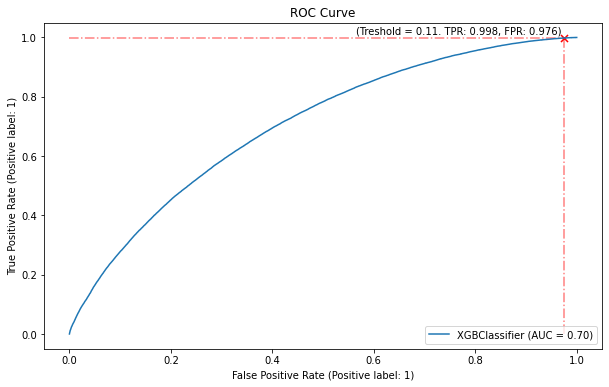

In [69]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import LearningCurveDisplay
import matplotlib.pyplot as plt

treshold = 0.11
y_score = final_classifier.predict_proba(X_test_transfd)[:, 1]
y_pred_at_tresh = np.where(y_score >= treshold, 1, 0)
conf_mat = confusion_matrix(y_test, y_pred_at_tresh)
tpr_at_tresh = conf_mat[1, 1] / (conf_mat[1, 1] + conf_mat[1, 0])
fpr_at_tresh = conf_mat[0, 1] / (conf_mat[0, 1] + conf_mat [0, 0])
# plot
fig, ax = plt.subplots(figsize=(10, 6))
RocCurveDisplay.from_estimator(
    final_classifier, X_test_transfd, y_test,
    ax=ax
    )
ax.scatter(fpr_at_tresh, tpr_at_tresh, s=50, c='red', marker='x')
ax.vlines(x=[fpr_at_tresh], ymin=0, ymax=[tpr_at_tresh], colors='red', ls='-.', alpha=0.5)
ax.hlines(y=[tpr_at_tresh], xmin=0, xmax=[fpr_at_tresh], colors='red', ls='-.', alpha=0.5)
ax.text(
    fpr_at_tresh - 0.41, 
    tpr_at_tresh + 0.015, 
    s=f'(Treshold = {treshold}. TPR: {tpr_at_tresh:.3f}, FPR: {fpr_at_tresh:.3f})')
ax.set_title('ROC Curve')
plt.show()

Using $0.12$ threshold, we got $0.998$ *True Positive Rate* at $0.976$ *False Positive Rate*. We falsely reject almost $97\%$ of `Good Loan`. This produce a very strict selection of loan, obviously because wrongly deciding to buy `Bad Loan` may lead to a more devastating outcome than rejecting `Good Loan`. By looking at this result, it is essential to report our model performance alongside its trade-off counterparts!

Then how can we get a lower *FPR*? The dataset itself may have its own nature of providing such challenging problem. Real-world dataset can be very complex and non-linear, making it difficult to find a decision boundary that accurately separates the different classes. However, it is most often possible to find effective solutions although may requires significant computational resource, time, and domain expertise. In simple words, create a better model!

Next, let's compare each of our `Selector`!

<a id="7.3-comparations"> </a>
### 7.3. Comparation of `Selector` Performance

This below lengthy code shows the process contained at each of the iteration:

In [72]:
return_A, investment_A = [], []
return_B, investment_B = [], []
return_C, investment_C = [], []
return_D, investment_D = [], []
iter_num = []
budget = 100000
# setting up iteration
n_iter = 300
for x_ in range(n_iter):
    iter_num.append(x_ + 1)
    sample_df = testing_df_test.sample(300)
    # Selector A
    r_A, i_A = SelectorA(budget, sample_df, return_total_funding=True)
    return_A.append(r_A)
    investment_A.append(i_A)
    # Selector B
    r_B, i_B = SelectorB(budget, sample_df, return_total_funding=True)
    return_B.append(r_B)
    investment_B.append(i_B)
    # Selector C
    r_C, i_C = SelectorC(budget, sample_df, return_total_funding=True)
    return_C.append(r_C)
    investment_C.append(i_C)
    # Selector D
    r_D, i_D = SelectorD(budget, sample_df, return_total_funding=True, treshold= 0.11, value_choice='potential_return')
    return_D.append(r_D)
    investment_D.append(i_D)
# create dataframe
return_df = pd.DataFrame({
    'iter_num': iter_num,
    'Selector A: non-informed decision': return_A,
    'Selector B: minimal-informed decision': return_B,
    'Selector C: model-informed, proba-based': return_C,
    'Selector D: model-informed, filtered': return_D
    })
return_df = pd.melt(
    return_df, id_vars=['iter_num'], value_name='actual_return'
    )
investment_df = pd.DataFrame({
    'iter_num': iter_num,
    'Selector A: non-informed decision': investment_A,
    'Selector B: minimal-informed decision': investment_B,
    'Selector C: model-informed, proba-based': investment_C,
    'Selector D: model-informed, filtered': investment_D
    })
investment_df = pd.melt(
    investment_df, id_vars=['iter_num'], value_name='total_investment' 
    )
compare_df = pd.merge(
    return_df, investment_df
    )
compare_df = compare_df.assign(
    roi=(compare_df.actual_return / compare_df.total_investment).replace([np.inf, -np.inf], 0)
    ).rename(columns={'variable': 'selector'})
compare_agg_df = compare_df.groupby('selector').aggregate(['mean', 'std'])
selectors = compare_df.selector.drop_duplicates().values
avg_return = compare_agg_df.iloc[:, 2]
std_return = compare_agg_df.iloc[:, 3]
avg_investment = compare_agg_df.iloc[:, 4]
std_investment = compare_agg_df.iloc[:, 5]
avg_roi = compare_agg_df.iloc[:, 6]
std_roi = compare_agg_df.iloc[:, 7]
return_leg = [
    f'{selector}, \navg = ${avg:,.0f}, std = ${std:,.0f}' for selector, avg, std in zip(selectors, avg_return, std_return)
    ]
investment_leg = [
    f'{selector}, \navg = ${avg:,.0f}, std = ${std:,.0f}' for selector, avg, std in zip(selectors, avg_investment, std_investment)
    ]
roi_leg = [
    f'{selector}, \navg = {avg:.3f}, std = {std:.3f}' for selector, avg, std in zip(selectors, avg_roi, std_roi)
    ]

Let's take a look at the distribution of return and amount of invested fund!

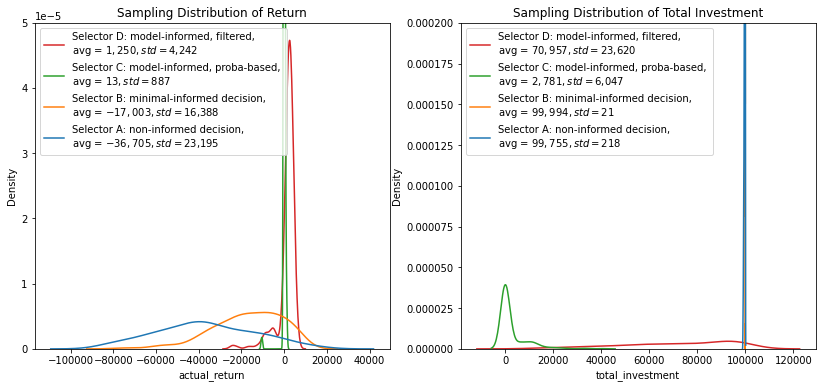

In [145]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.kdeplot(data=compare_df, x='actual_return', hue='selector', ax=ax[0])
sns.kdeplot(data=compare_df, x='total_investment', hue='selector', ax=ax[1])
ax[0].legend(return_leg[-1::-1])
ax[0].set_ylim(0, 5e-5)
ax[0].set_title('Sampling Distribution of Return')
ax[1].legend(investment_leg[-1::-1])
ax[1].set_title('Sampling Distribution of Total Investment')
ax[1].set_ylim(0, 2e-4)
plt.show()

As we can see the model-informed loan selector, on average, has a better return than the selector without model involvement. Moreover, we can inspect that `Selector C` may provide lower investment risk than `Selector D` by simply looking at the standard deviation value (which means the deviation, on average, from the likelihood of the return), but the return is also lower (as some said, low risk low return). Inspect the distribution that has a higher frequency of having negative return.

Each of the models has its unique style for investing. For `Selector A` and `Selector B`, the investment is always maximized since there is always their-kind-of loan available to choose. `Selector C` is rather playing-it-save with the investment. `Selector D` is always looking for opportunity, if any, as we can see the investment amount is almost uniformly distributed.

Notice that, for `Selector D`, there is *second mode* that appears in the distribution, which suggest unusual observations may exist.

Both of those variable commonly considered in a metric called *Return of Investment (ROI)*, which is simply the yield return. Again, let's compare the ROI for those selectors!

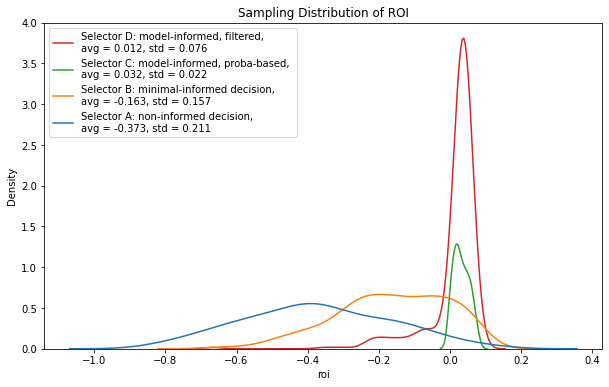

In [75]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(data=compare_df, x='roi', hue='selector', ax=ax)
ax.legend(return_leg[-1::-1])
ax.set_title('Sampling Distribution of Return')
ax.legend(roi_leg[-1::-1])
ax.set_title('Sampling Distribution of ROI')
plt.show()

Selector that utilize prediction model tends to have positive *ROI* rather than other models. Moreover, `Selector D` tends to give consistent results among others. 

So, do you agree if the model may help us delivering informed decision? Or is there any better way to select the loan?

<a id="8-final-words"> </a>
## 8. Final Words

I already demonstrate simple process of developing prediction model and implementation to solve real problem. We looked at how to prepare the dataset, selecting the potential model, doing some feature engineering and adjusting the model parameters to get optimized model.

The model selection above is rather a simple approach to select the model. Classification algorithms should have a large improvement after some sort of tweaks is performed. For example, many classification algorithm works better with smaller dimension of training instances so we can do some sort of feature subsetting (for example, *RFE* and *Sequential Feature Selection*) and step back to the iteration to inspect each of the algorithm's potential. *KNN Classifier* is punished harder in higher dimensional spaces, due to its difficulties in finding neighbours. It is known to perform better with some of dimensionality reduction method, for example with using *Neighborhood Component Analysis*: a supervised dimensionality reduction method. Considering those, it is also possible to develop *AutoML* for model selection, if the resource is available.

After all, we should be able to show that a machine learning model can be useful to tackle real world problems, which I already tried to do in this analysis. Otherwise, there is no purpose of doing hefty work of developing a model.